# Model Training

### Import Libraries & Load Metadata

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import cv2
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras.backend as K

In [2]:
meta_path = "../data/cibs-ddsm/metadata/meta.csv"
df = pd.read_csv(meta_path)

### Load Images into Memory

In [3]:
def load_images(df, size=(224, 224)):
    X, y = [], []
    for _, row in df.iterrows():
        img = cv2.imread(row["processed_path"], cv2.IMREAD_GRAYSCALE)
        if img is not None:
            X.append(img)
            y.append(row["label"])
    X = np.array(X)[..., np.newaxis] / 255.0  
    y = np.array(y)
    return X, y

### Split dataset

In [7]:
from sklearn.model_selection import train_test_split

# First split into train and test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
X_train_full, y_train_full = load_images(train_df)
X_test, y_test = load_images(test_df)

# Now split X_train_full into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# Reshape labels
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

### Build CNN Model with Augmentation

### Batch normalisation 

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, RandomFlip,
                                     RandomRotation, RandomZoom)

model = Sequential([
    Input(shape=(224, 224, 1)), 
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

In [9]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        eps = K.epsilon()
        y_pred = K.clip(y_pred, eps, 1. - eps)
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        return -K.mean(alpha * K.pow(1. - pt, gamma) * K.log(pt))
    return focal_loss_fixed

In [10]:
from tensorflow.keras.metrics import AUC

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

## Check for label distribution

In [11]:
import pandas as pd
df = pd.read_csv("../data/cibs-ddsm/metadata/labels_resolved.csv")
df["label"].value_counts()

label
0    2111
1    1457
Name: count, dtype: int64

In [12]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1351, 1: 932}


## Calculate Class Weights

In [13]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train.flatten()),
    y=y_train.flatten()
)
class_weights = dict(enumerate(class_weights_array))

### Add early stopping

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

In [16]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

In [17]:
print(X_train.shape, y_train.shape)

(1826, 224, 224, 1) (1826,)


In [18]:
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - accuracy: 0.5022 - auc: 0.4900 - loss: 0.9687 - val_accuracy: 0.5908 - val_auc: 0.5220 - val_loss: 0.6891
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.4932 - auc: 0.4973 - loss: 0.7101 - val_accuracy: 0.4311 - val_auc: 0.4673 - val_loss: 0.6940
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - accuracy: 0.4828 - auc: 0.4987 - loss: 0.6903 - val_accuracy: 0.4661 - val_auc: 0.5068 - val_loss: 0.6934
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 222ms/step - accuracy: 0.4455 - auc: 0.4872 - loss: 0.6950 - val_accuracy: 0.4026 - val_auc: 0.4566 - val_loss: 0.6942
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 222ms/step - accuracy: 0.4212 - auc: 0.4950 - loss: 0.6932 - val_accuracy: 0.4092 - val_auc: 0.4722 - val_loss: 0.6946
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 221ms/step - accuracy: 0.4614 - auc: 0.5189 - loss: 0.6910 - val_accuracy: 0.5317 - val_auc: 0.4965 - val_loss: 0.6929


In [19]:
results = model.evaluate(X_test, y_test, return_dict=True)
print(f"Test Loss: {results['loss']:.4f}")
print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test AUC: {results['auc']:.4f}")
model.save("../results/model_weights/final_model.h5")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5922 - auc: 0.4990 - loss: 0.6928


Test Loss: 0.6922
Test Accuracy: 0.5910
Test AUC: 0.5051


In [22]:
X_test_rgb = np.repeat(X_test, 3, axis=-1)

In [37]:
thresholds = [0.2, 0.3, 0.4, 0.5]
for t in thresholds:
    y_pred = (y_probs > t).astype(int)
    print(f"\n--- Threshold: {t} ---")
    print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))


--- Threshold: 0.2 ---
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       422
   Malignant       0.41      1.00      0.58       292

    accuracy                           0.41       714
   macro avg       0.20      0.50      0.29       714
weighted avg       0.17      0.41      0.24       714


--- Threshold: 0.3 ---
              precision    recall  f1-score   support

      Benign       0.57      0.21      0.31       422
   Malignant       0.40      0.77      0.53       292

    accuracy                           0.44       714
   macro avg       0.49      0.49      0.42       714
weighted avg       0.50      0.44      0.40       714


--- Threshold: 0.4 ---
              precision    recall  f1-score   support

      Benign       0.59      0.88      0.70       422
   Malignant       0.37      0.10      0.16       292

    accuracy                           0.56       714
   macro avg       0.48      0.49      0.43       714
we

/Users/justinlim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/justinlim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/justinlim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/justinlim

In [38]:
from sklearn.metrics import classification_report, roc_auc_score

# Get predicted probabilities
y_probs = model.predict(X_test, verbose=1)

# Lower the threshold
y_pred = (y_probs > 0.3).astype(int) 

# Print metrics
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

# AUC remains based on raw probs
auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {auc:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
              precision    recall  f1-score   support

      Benign       0.57      0.21      0.31       422
   Malignant       0.40      0.77      0.53       292

    accuracy                           0.44       714
   macro avg       0.49      0.49      0.42       714
weighted avg       0.50      0.44      0.40       714

ROC AUC Score: 0.5046


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


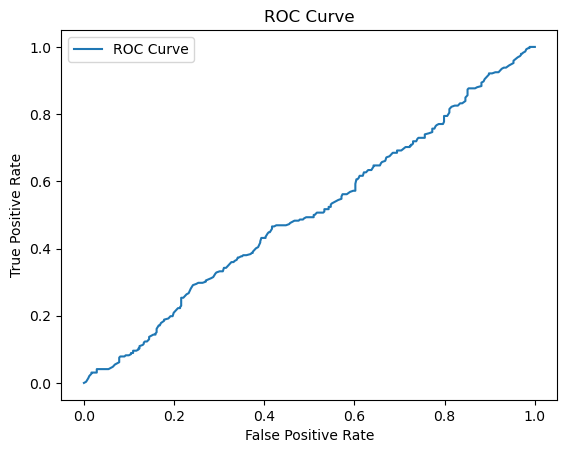

ROC AUC Score: 0.5045770304486139


In [41]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test).ravel()
y_pred = (y_pred_probs > 0.3).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_probs))

In [42]:
np.save("../data/cibs-ddsm/processed/X_test.npy", X_test)
np.save("../data/cibs-ddsm/processed/y_test.npy", y_test)